 <font size="15">
SKT012.05.02.03_scATACseqChiouT2D_DeepLearning-PerformanceAnalysis-StrideSize50Chromosomes-OriginalParameters.ipynb
</font> 

In [1]:
import time
# get the start time
StartTime = time.time()



# Performance Analysis

## Import Packages

In [2]:
import tensorflow
import keras
import shap
print(tensorflow.__version__)
print(keras.__version__)
print(shap.__version__)


Using TensorFlow backend.
/data/leuven/332/vsc33293/miniconda/envs/Python_DeepPancreas_gpu_TF1.15/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.15.0
2.2.4
0.39.0


In [3]:
import sys
import optparse
from array import *

import tensorflow
import numpy as np

import matplotlib
#matplotlib.use('pdf')
import matplotlib.pyplot as plt

import sklearn
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score

from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, Concatenate, PReLU 
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Layer, average, Input
from keras.models import Model
from keras.utils import plot_model

## Defining Essential Functions

In [4]:
def get_output(input_layer, hidden_layers):
    output = input_layer
    for hidden_layer in hidden_layers: 
        output = hidden_layer(output)
    return output

def build_model():
    forward_input = Input(shape=seq_shape)
    reverse_input = Input(shape=seq_shape)

    hidden_layers = [
        Conv1D(128, kernel_size=20, padding="valid", activation='relu', kernel_initializer='random_uniform'),
        MaxPooling1D(pool_size=10, strides=10, padding='valid'),
        Dropout(0.2),
        TimeDistributed(Dense(128, activation='relu')),
        Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)),
        Dropout(0.2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(len(selected_classes), activation='sigmoid')]
    forward_output = get_output(forward_input, hidden_layers)     
    reverse_output = get_output(reverse_input, hidden_layers)
    output = average([forward_output, reverse_output])
    model = Model(input=[forward_input, reverse_input], output=output)

    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def readfile(filename):
    ids = []
    ids_d = {}
    seqs = {}
    classes = {}
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    seq = []
    for line in lines:
        if line[0] == '>':
            ids.append(line[1:].rstrip('\n'))
            if line[1:].rstrip('\n').split('_')[0] not in seqs:
                seqs[line[1:].rstrip('\n').split('_')[0]] = []
            if line[1:].rstrip('\n').split('_')[0] not in ids_d:
                ids_d[line[1:].rstrip('\n').split('_')[0]] = line[1:].rstrip('\n').split('_')[0]
            if line[1:].rstrip('\n').split('_')[0] not in classes:
                classes[line[1:].rstrip('\n').split('_')[0]] = np.zeros(NUM_CLASSES)
            classes[line[1:].rstrip('\n').split('_')[0]][int(line[1:].rstrip('\n').split('_')[1])-1] = 1        
            if seq != []: seqs[ids[-2].split('_')[0]]= ("".join(seq))
            seq = []
        else:
            seq.append(line.rstrip('\n').upper())
    if seq != []:
        seqs[ids[-1].split('_')[0]]=("".join(seq))
    return ids,ids_d,seqs,classes

def one_hot_encode_along_row_axis(sequence):
    to_return = np.zeros((1,len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return[0],
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

def create_plots(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(foldername + 'accuracy.png')
    plt.clf()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(foldername + 'loss.png')
    plt.clf()
    
def json_hdf5_to_model(json_filename, hdf5_filename):  
    with open(json_filename, 'r') as f:
        model = model_from_json(f.read())
    model.load_weights(hdf5_filename)
    return model

def loc_to_model_loss(loc):
    return json_hdf5_to_model(loc + 'model.json', loc + 'model_best_loss.hdf5')

def shuffle_label(label):
    for i in range(len(label.T)):
        label.T[i] = shuffle(label.T[i])
    return label

def calculate_roc_pr(score, label):
    num_classes = label.shape[1]
    output = np.zeros((num_classes, 2))
    for i in range(num_classes):
        class_label = label[:, i]
        if len(np.unique(class_label)) > 1:  # Check if more than one class present
            roc_ = roc_auc_score(class_label, score[:, i])
            pr_ = average_precision_score(class_label, score[:, i])
            output[i] = [roc_, pr_]
    return output

## Input Data

In [5]:
NUM_CLASSES = 97
selected_classes = np.arange(NUM_CLASSES)
SEQ_LEN = 500
SEQ_DIM = 4
seq_shape = (SEQ_LEN, SEQ_DIM)


import os
DeepLearningFolder = '/lustre1/project/stg_00041/SanKit/SKT012_Chiou_snATAC_Pancreas/Data/DeepLearning/'
InputFolder = DeepLearningFolder + 'InputFileHumanPancreas/'
TrainedModelFolder = DeepLearningFolder + 'OutputFileHumanPancreas/TrainedModelStrideSize50ChromosomesTF1_15/20230724/'
OutputFolder = TrainedModelFolder + 'ModelPerformance/'
os.makedirs(OutputFolder, exist_ok=True)



train_filename = InputFolder + 'MergedFile_WoChr2_WoChr11_extendedStrideSize50.fa'
valid_filename = InputFolder + 'MergedFile_Chr2.fa'
test_filename = InputFolder + 'MergedFile_Chr11.fa'



print("Prepare Trainingset input...")
train_ids, train_ids_d, train_seqs, train_classes = readfile(train_filename)
X_train = np.array([one_hot_encode_along_row_axis(train_seqs[id]) for id in train_ids_d]).squeeze(axis=1)
y_train = np.array([train_classes[id] for id in train_ids_d])
y_train = y_train[:,selected_classes]
X_train = X_train[y_train.sum(axis=1)>0]
y_train = y_train[y_train.sum(axis=1)>0]
X_train_rc = X_train[:,::-1,::-1]
train_data = [X_train, X_train_rc]

print("Prepare validationset input...")
valid_ids, valid_ids_d, valid_seqs, valid_classes = readfile(valid_filename)
X_valid = np.array([one_hot_encode_along_row_axis(valid_seqs[id]) for id in valid_ids_d]).squeeze(axis=1)
y_valid = np.array([valid_classes[id] for id in valid_ids_d])
y_valid = y_valid[:,selected_classes]
X_valid = X_valid[y_valid.sum(axis=1)>0]
y_valid = y_valid[y_valid.sum(axis=1)>0]
X_valid_rc = X_valid[:,::-1,::-1]
valid_data = [X_valid, X_valid_rc]


print("Prepare Testset input...")

test_ids, test_ids_d, test_seqs, test_classes = readfile(test_filename)
X_test = np.array([one_hot_encode_along_row_axis(test_seqs[id]) for id in test_ids_d]).squeeze(axis=1)
y_test = np.array([test_classes[id] for id in test_ids_d])
y_test = y_test[:,selected_classes]
X_test = X_test[y_test.sum(axis=1)>0]
y_test = y_test[y_test.sum(axis=1)>0]
X_test_rc = X_test[:,::-1,::-1]
test_data = [X_test, X_test_rc]

Prepare Trainingset input...
Prepare validationset input...
Prepare Testset input...


## Loading the trained DeepPancreas Model

In [6]:
trained_model = loc_to_model_loss(TrainedModelFolder)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








In [8]:
trained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 4)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 500, 4)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 481, 128)     10368       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 48, 128)      0           conv1d_1[0][0]                   
          

## Plotting and saving auROC and auPR values

In [9]:
print('calculate roc and pr...')
roc_pr_dict = {"train": {}, "valid":{}, "test": {}, "shuffle": {}}

calculate roc and pr...


In [10]:
roc_pr_dict["train"]["score"] = trained_model.predict(train_data)
roc_pr_dict["train"]["label"] = y_train

In [11]:
roc_pr_dict["valid"]["score"] = trained_model.predict(valid_data)
roc_pr_dict["valid"]["label"] = y_valid

In [12]:
roc_pr_dict["test"]["score"] = trained_model.predict(test_data)
roc_pr_dict["test"]["label"] = y_test

In [13]:
roc_pr_dict["shuffle"]["score"] = np.array(roc_pr_dict["train"]["score"], copy=True)
roc_pr_dict["shuffle"]["label"] = shuffle_label(np.array(y_train, copy=True))

In [14]:
for sets in ["train", "valid", "test", "shuffle"]:
    roc_pr_dict[sets]["roc_pr"] = calculate_roc_pr(roc_pr_dict[sets]["score"], roc_pr_dict[sets]["label"])

In [15]:
print('calculate roc and pr...')
roc_pr_dict = {"train": {}, "valid": {}, "test": {}, "shuffle": {}}
roc_pr_dict["train"]["score"] = trained_model.predict(train_data)
roc_pr_dict["train"]["label"] = y_train
roc_pr_dict["valid"]["score"] = trained_model.predict(valid_data)
roc_pr_dict["valid"]["label"] = y_valid
roc_pr_dict["test"]["score"] = trained_model.predict(test_data)
roc_pr_dict["test"]["label"] = y_test
roc_pr_dict["shuffle"]["score"] = np.array(roc_pr_dict["train"]["score"], copy=True)
roc_pr_dict["shuffle"]["label"] = shuffle_label(np.array(y_train, copy=True))

for sets in ["train", "valid", "test", "shuffle"]:
    roc_pr_dict[sets]["roc_pr"] = calculate_roc_pr(roc_pr_dict[sets]["score"], roc_pr_dict[sets]["label"])

calculate roc and pr...


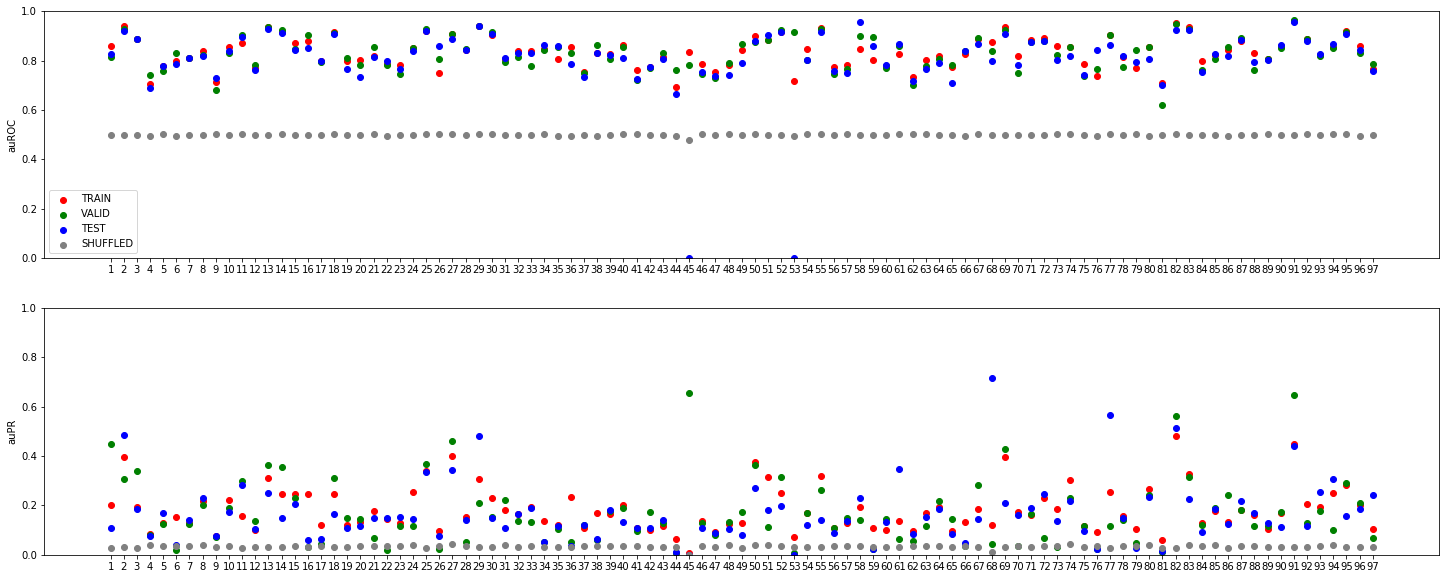

In [16]:
fig = plt.figure(figsize=(25, 10))

ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('auROC')
ax.scatter(selected_classes, roc_pr_dict["train"]["roc_pr"].T[0], color='red', label='TRAIN')
ax.scatter(selected_classes, roc_pr_dict["valid"]["roc_pr"].T[0], color='green', label='VALID')
ax.scatter(selected_classes, roc_pr_dict["test"]["roc_pr"].T[0], color='blue', label='TEST')
ax.scatter(selected_classes, roc_pr_dict["shuffle"]["roc_pr"].T[0], color='gray', label='SHUFFLED')
ax.set_ylim([0, 1])
_ = plt.xticks(range(len(selected_classes)),range(1,len(selected_classes)+1))
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('auPR')
ax.scatter(selected_classes, roc_pr_dict["train"]["roc_pr"].T[1], color='red', label='TRAIN')
ax.scatter(selected_classes, roc_pr_dict["valid"]["roc_pr"].T[1], color='green', label='VALID')
ax.scatter(selected_classes, roc_pr_dict["test"]["roc_pr"].T[1], color='blue', label='TEST')
ax.scatter(selected_classes, roc_pr_dict["shuffle"]["roc_pr"].T[1], color='gray', label='SHUFFLED')
ax.set_ylim([0, 1])
_ = plt.xticks(range(len(selected_classes)),range(1,len(selected_classes)+1))

plt.savefig(OutputFolder + 'Train_Valid_Test-auROC_auPR.png')

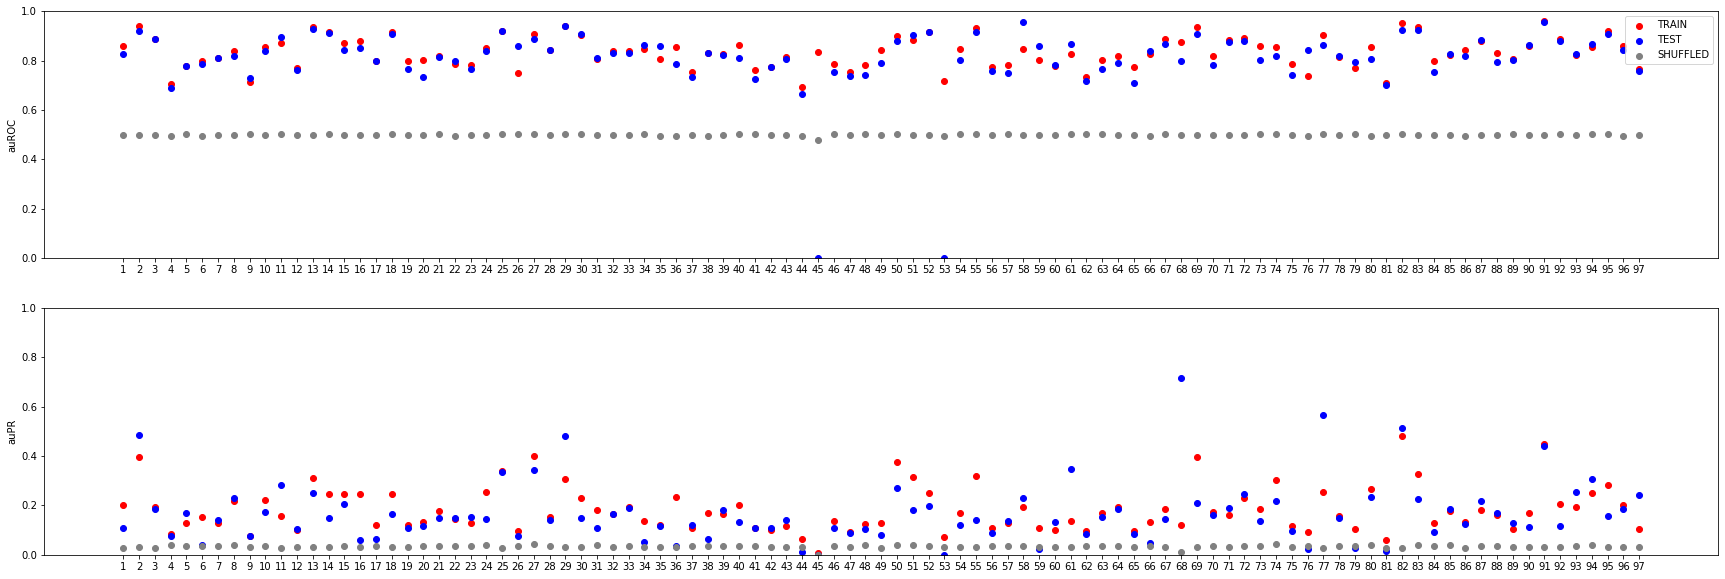

In [22]:
# plot auROC and auPR values

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('auROC')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["train"]["roc_pr"].T[0], color='red', label='TRAIN')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["test"]["roc_pr"].T[0], color='blue', label='TEST')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["shuffle"]["roc_pr"].T[0], color='gray', label='SHUFFLED')
ax.set_ylim([0, 1])
_ = plt.xticks(range(len(selected_classes)),range(1,len(selected_classes)+1))
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('auPR')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["train"]["roc_pr"].T[1], color='red', label='TRAIN')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["test"]["roc_pr"].T[1], color='blue', label='TEST')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["shuffle"]["roc_pr"].T[1], color='gray', label='SHUFFLED')
ax.set_ylim([0, 1])
_ = plt.xticks(range(len(selected_classes)),range(1,len(selected_classes)+1))

plt.savefig(OutputFolder + 'auROC_auPR.png')

In [18]:
# Define the values for each group data

Topics = np.arange(NUM_CLASSES)
ROC_Train = roc_pr_dict["train"]["roc_pr"].T[0]
ROC_Test = roc_pr_dict["test"]["roc_pr"].T[0]
ROC_Shuffle = roc_pr_dict["shuffle"]["roc_pr"].T[0]
PR_train = roc_pr_dict["train"]["roc_pr"].T[1]
PR_Test = roc_pr_dict["test"]["roc_pr"].T[1]
PR_Shuffle = roc_pr_dict["shuffle"]["roc_pr"].T[1]


In [19]:
from scipy.stats import ttest_rel
alpha = 0.05

ttest_roc, p_value_roc = ttest_rel(ROC_Train, ROC_Test)
if p_value_roc < alpha:
    print("Reject null hypothesis for ROC, the means are different")
else:
    print("Fail to reject null hypothesis for ROC, the means are not different")

ttest_pr, p_value_pr = ttest_rel(PR_train, PR_Test)
if p_value_pr < alpha:
    print("Reject null hypothesis for PR, the means are different")
else:
    print("Fail to reject null hypothesis for PR, the means are not different")


Reject null hypothesis for ROC, the means are different
Fail to reject null hypothesis for PR, the means are not different


In [20]:
# Save auROC and auPR values in csv-file

import numpy as np
import pandas as pd

header = ['Topics', 'ROC_Train', 'ROC_Test', 'ROC_Shuffle', 'PR_Train', 'PR_Test', 'PR_Shuffle']
stack = np.stack((Topics, ROC_Train, ROC_Test, ROC_Shuffle, PR_train, PR_Test, PR_Shuffle), axis = 1)
df = pd.DataFrame(stack, columns=header)
print(df)
df.to_csv(OutputFolder + 'auROC_auPR.csv', header=True, sep=' ')

    Topics  ROC_Train  ROC_Test  ROC_Shuffle  PR_Train   PR_Test  PR_Shuffle
0      0.0   0.860666  0.824809     0.499751  0.201070  0.109765    0.028700
1      1.0   0.940073  0.920103     0.499055  0.397472  0.484272    0.032467
2      2.0   0.886039  0.887899     0.500355  0.193776  0.186627    0.027925
3      3.0   0.704270  0.690223     0.495523  0.083566  0.074110    0.037792
4      4.0   0.778604  0.778055     0.501089  0.129397  0.169134    0.037346
..     ...        ...       ...          ...       ...       ...         ...
92    92.0   0.824510  0.826801     0.499961  0.193951  0.253074    0.037419
93    93.0   0.853104  0.868381     0.501249  0.251467  0.305461    0.040248
94    94.0   0.920758  0.909694     0.502989  0.282398  0.157955    0.029725
95    95.0   0.859718  0.841461     0.496398  0.200411  0.184598    0.033261
96    96.0   0.766034  0.759464     0.500752  0.105306  0.243671    0.032957

[97 rows x 7 columns]


## Print Execution time

In [21]:
# get the execution time
EndTime = time.time()
elapsed_time = EndTime - StartTime
print('Execution time:', elapsed_time, 'seconds')
Minutes = elapsed_time / 60
print('Execution time:', Minutes, 'minutes')
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 1546.323371887207 seconds
Execution time: 25.77205619812012 minutes
Execution time: 00:25:46
